In [7]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [8]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [9]:
from imutils import paths

In [10]:
imagePaths = sorted(list(paths.list_images("chest_xray/train")))

# random shuffle
random.seed(42)
random.shuffle(imagePaths)

data = []
labels = []
image_dims = (224, 224, 3)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_dims[1], image_dims[0]))
    image = img_to_array(image)
    data.append(image)
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)
    
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("{} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

5216 images (6134.02MB)


In [11]:
data = np.array(data)
label = np.array(labels)
print(data.shape)

(5216, 224, 224, 3)


In [12]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# total 4 labels
print("class labels:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

class labels:
1. NORMAL
2. PNEUMONIA


In [13]:
def MobileNetV2_model(learning_rate, input_shape,class_number):
    baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers[:-4]:
        layer.trainable = False
   
    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(class_number, activation='softmax'))

    return model

In [14]:
bs = 32
lr = 0.0001
size = (224, 224)
shape = (224,224, 3) 
epochs = 10
class_number = 2

In [15]:
model = MobileNetV2_model(lr,shape,class_number)
model.compile(loss= "categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [16]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)




# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')




test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/var/folders/6r/w6lhlth93yn4c397t0sc0gpw0000gn/T/ipykernel_1830/1525006258.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


522/522 [==============================] - 66s 124ms/step - loss: 0.3676 - accuracy: 0.8978 - val_loss: 0.4843 - val_accuracy: 0.8462


In [21]:
import tensorflow as tf
from keras.models import load_model

model.save('chest_xray_mobilenet.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
from keras.models import load_model

In [23]:
from keras.preprocessing import image

In [24]:
from keras.applications.vgg16 import preprocess_input

In [25]:
import numpy as np

In [26]:
model=load_model('chest_xray_mobilenet.h5')

In [27]:
#img=image.load_img('chest_xray/test/NORMAL/IM-0105-0001.jpeg',target_size=(224,224))

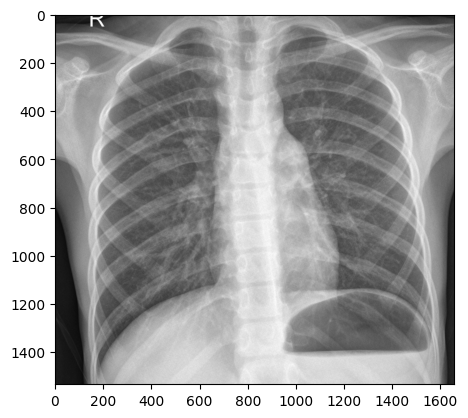

In [28]:
img = cv2.imread('chest_xray/test/NORMAL/IM-0033-0001.jpeg')
plt.imshow(img)
plt.show()

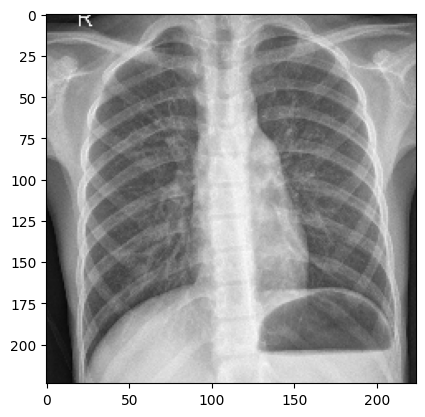

In [29]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [30]:
yhat = model.predict(np.expand_dims(resize/224, 0))

1/1 [==============================] - 0s 468ms/step


In [31]:
yhat[0][0]

0.83579445

In [32]:
if yhat[0][0] > 0.5: 
    print(f'Predicted class is Normal')
else:
    print(f'Predicted class is of Pneumonia')

Predicted class is Normal
